## This notebook works in neuralprophet environment 

## Assumption: 
  * The time series are stationary 
    - test it using ADF and KPSS test
  * each of the time series is dependent on all of the time series, including given time series as well. 
    - test it using Granger’s Causality Test and Cointegration Test
  * After forecast, check for pattern in the residuals. 
    - test Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
    
    
## To do: 
  * Read about Granger’s Causality Test and Cointegration Test in context of VAR model.
  * Add the stationarity test, and make the time series stationary if needed, for better performance of VAR model. 
  * Add better validation method, run on multiple test samples instead of just one. similar to what is done in DLinear 
      - At present: prediction is done on one sample, collect multiple samples for test dataset and then use walk foreward method for validation. 
  
  
## Summary 
  * Did not work well for divvy bikes case with 3 months data, 
      - the number of parameters with this configuration would be 200x200x336 = 13440000 = 13.44 M parameters 
      - works ok,  when data is not scaled but after standardscaler the prediction is always ZERO. 
      - Reason: The dataset (X) have a lot of zeros, and likely the standard scalar is not doing an appropriate job here. 
      
      
##### MAPE discussion 

   - MAPE by definition is problematic for two cases: 
       1. when observed is ZERO, this will result in inf, or divide by zero error 
       2. when observed is ZERO, and predicted is also ZERO. 
      - Problem 1. is fixed in the SMAPE by definition but SMAPE will have trouble with 2. as well. 
      - MAPE from sklearn partially fix this. It does not throw nan and also takes care of proble 2. by avoiding divide by ZERO. It takes max of epsilon, $y_{observed}$ .
      - This fix the issue when both predicted and observed are zero but when ONLY observed is zero, divide by epsilon will result in a huge number (not infinity). 
      - Both these problems can be avoided by the use of zero-inflated SMAPE. It will use the predicted value as the error if observed is ZERO. 


In [2]:
# !pip install statsmodels

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler, MinMaxScaler


## custom class for metrics calculation 
#from ForecastMetrics import ForecastMetrics
import ForecastMetrics
from importlib import reload
 
reload(ForecastMetrics)


<module 'ForecastMetrics' from '/Users/raman/JupyterNotebooks/Comparison_Multivariate/ForecastMetrics.py'>

## Data prepration 
If we have k time series and we want to auto regress using last p values then 

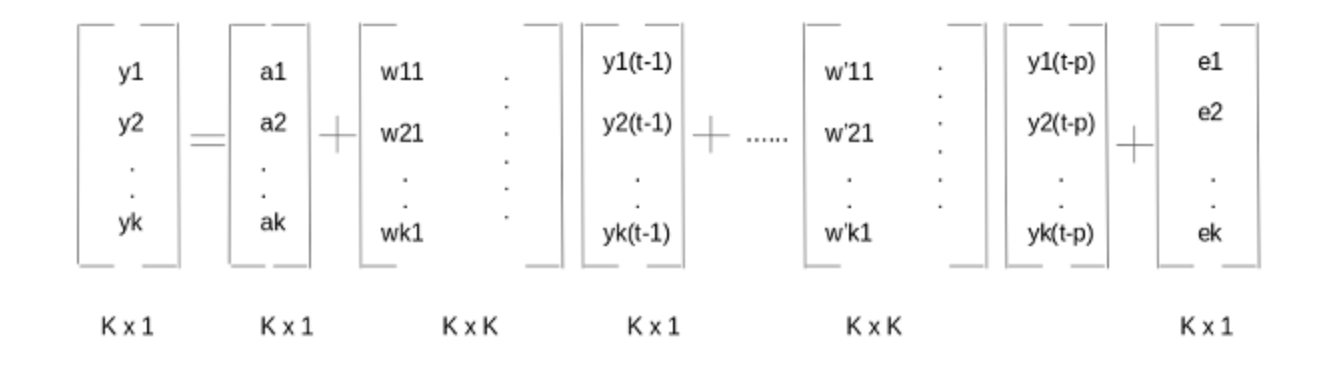



In [3]:
## Read the dataset which is prepared for VAR model

def read_data(csvfile="", model=""):
    mdata = pd.read_csv(csvfile,
                        index_col="date")
    return mdata

datasets={"Divvy": 'dataset/DivvyBikes/df2021-8-9-10_VAR.csv',
         "ETTh1":  'dataset/ETTh1.csv',
         "ETTh2":  'dataset/ETTh2.csv',
         "ETTm1":  'dataset/ETTm1.csv',
         "ETTm2":  'dataset/ETTm2.csv',
         "Electricity":  'dataset/electricity.csv', # does not converge, kernal died 
         "Exchange":  'dataset/exchange_rate.csv',
         "Weather":  'dataset/weather.csv',
         "Traffic":  'dataset/traffic.csv', # does not converge, kernal died 
         "Kaggle_Sales":  'dataset/KaggleStoreSales/train_VAR.csv',
         "HDD":  '',
         "Motion":  '',
         "NASA":  ''
         }


In [4]:
!ls dataset

DivvyBikes           ETTm2.csv            national_illness.csv
ETTh1.csv            KaggleStoreSales     traffic.csv
ETTh2.csv            electricity.csv      weather.csv
ETTm1.csv            exchange_rate.csv


## Constants

In [5]:
dataset="Electricity"


fixed={"Divvy":{
    "lag": 336,
    "horizion":24,
    "clipforecast":True ,
    "clipvalue":0,
    "splittingdate":"2021-10-31 00:00:00" ## Divvy 
    },
       "Kaggle_Sales":{
    "lag": 336,
    "horizion":96,
    "clipforecast":False ,
    "clipvalue":0,
    "splittingdate":"2021-09-26 00:00:00" ## 96 days
    },
        "ETTh1":{
    "lag": 336,
    "horizion":96,
    "clipforecast":False ,
    "clipvalue":0,
    "splittingdate":"2018-06-22 20:00:00" ## 96 days
    },

        "ETTh2":{
    "lag": 336,
    "horizion":96,
    "clipforecast":False ,
    "clipvalue":0,
    "splittingdate":"2018-06-22 20:00:00" ## 96 days
        },
       
        "ETTm1":{
    "lag": 336,
    "horizion":96,
    "clipforecast":False ,
    "clipvalue":0,
    "splittingdate":"2018-06-25 20:00:00" ## 96 days
        },
       
        "ETTm2":{
    "lag": 336,
    "horizion":96,
    "clipforecast":False ,
    "clipvalue":0,
    "splittingdate":"2018-06-25 20:00:00" ## 96 days
        },

        "Electricity":{
    "lag": 336,
    "horizion":96,
    "clipforecast":False ,
    "clipvalue":0,
    "splittingdate":"2019-06-28 02:00:00" ## 96 days
        },

        "Exchange":{
    "lag": 336,
    "horizion":96,
    "clipforecast":False ,
    "clipvalue":0,
    "splittingdate":"2010-07-07 00:00:00" ## 96 days
        },

        "Weather":{
    "lag": 336,
    "horizion":96,
    "clipforecast":False ,
    "clipvalue":0,
    "splittingdate":"2020-12-31 08:10:00" ## 96 days
        },

        "Traffic":{
    "lag": 336,
    "horizion":96,
    "clipforecast":False ,
    "clipvalue":0,
    "splittingdate":"2018-06-28 02:00:00" ## 96 days
        }


       
      }
lag = fixed[dataset]["lag"]
horizion = fixed[dataset]["horizion"]
clipforecast = fixed[dataset]["clipforecast"]
clipvalue = fixed[dataset]["clipvalue"]
splittingdate = fixed[dataset]["splittingdate"]

In [6]:
fixed[dataset]

{'lag': 336,
 'horizion': 96,
 'clipforecast': False,
 'clipvalue': 0,
 'splittingdate': '2019-06-28 02:00:00'}

In [7]:
data = read_data(datasets[dataset])
if dataset=="Exchange":
    data.index = pd.to_datetime(data.index)
if (dataset=="Traffic") or  (dataset=="Electricity"):
    cols=list(data)
    data=data[cols[:200]]
    
    
data[-96:].index[0]

'2019-06-28 02:00:00'

In [8]:
#data[data.index>='2010/7/7 0:00']
#data.index = pd.to_datetime(data.index)
data.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
195    float64
196    float64
197    float64
198    float64
199    float64
Length: 200, dtype: object

In [11]:
for icol in list(data):
    data[icol] = data[icol].astype('float32')
    

In [12]:
data.dtypes

0      float32
1      float32
2      float32
3      float32
4      float32
        ...   
195    float32
196    float32
197    float32
198    float32
199    float32
Length: 200, dtype: object

In [13]:
data[-96:]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
date,,,,,,,,,,,,,,,,,,,,,
2019-06-28 02:00:00,12.0,79.0,8.0,681.0,363.0,815.0,23.0,1106.0,229.0,242.0,...,165.0,276.0,185.0,1854.0,384.0,180.0,1055.0,224.0,756.0,6755.0
2019-06-28 03:00:00,11.0,73.0,0.0,548.0,315.0,695.0,17.0,1035.0,204.0,214.0,...,168.0,243.0,179.0,1825.0,355.0,183.0,1010.0,222.0,809.0,6829.0
2019-06-28 04:00:00,11.0,71.0,0.0,485.0,285.0,659.0,17.0,905.0,197.0,194.0,...,175.0,227.0,174.0,1899.0,334.0,176.0,997.0,230.0,760.0,6187.0
2019-06-28 05:00:00,12.0,68.0,7.0,454.0,272.0,638.0,16.0,996.0,189.0,201.0,...,180.0,221.0,164.0,1857.0,338.0,184.0,1003.0,223.0,763.0,6744.0
2019-06-28 06:00:00,11.0,70.0,7.0,426.0,259.0,599.0,18.0,874.0,197.0,205.0,...,182.0,225.0,167.0,1821.0,314.0,180.0,1007.0,220.0,723.0,6618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01 21:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,351.0,...,272.0,425.0,303.0,2568.0,671.0,277.0,1325.0,405.0,1397.0,6928.0
2019-07-01 22:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,327.0,...,170.0,297.0,203.0,1698.0,622.0,228.0,927.0,266.0,1058.0,5595.0
2019-07-01 23:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,283.0,...,206.0,289.0,190.0,1586.0,589.0,226.0,945.0,225.0,964.0,5422.0


## Read data and normalise 

In [14]:

def Scaler(df_train, df_test):
    print (df_train.shape, df_test.shape)
    cols=list(df_train)
    
    train_index_=df_train.index
    test_index_=df_test.index

    scaler = StandardScaler()
    #scaler = MinMaxScaler()

    
    scaler.fit(df_train)
    
    df_train_scaled = scaler.transform(df_train)
    df_test_scaled = scaler.transform(df_test)
    
    def add_colname(df, index):
        df=pd.DataFrame(data=df,columns=cols)
        df.index=index
        return df 
    df_train_scaled = add_colname(df_train_scaled, train_index_) 
    df_test_scaled = add_colname(df_test_scaled, test_index_) 

    return df_train_scaled, df_test_scaled


In [15]:
#df_train, df_test =  Scaler(data[(data.index<"2021-10-31 00:00:00")],  data[(data.index>="2021-10-31 00:00:00")] )#,list(data) )

#df_train, df_test =  (data[(data.index<"2021-10-31 00:00:00")],  data[(data.index>="2021-10-31 00:00:00")] )

df_train, df_test =  (data[(data.index<splittingdate)],  data[(data.index>=splittingdate)] )


In [16]:
df_train.shape, df_test.shape

((26208, 200), (96, 200))

In [17]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,163.0,325.0,178.0,1634.0,358.0,185.0,1090.0,246.0,689.0,7162.0
2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,165.0,325.0,163.0,1601.0,335.0,203.0,1075.0,246.0,733.0,7150.0
2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,150.0,334.0,153.0,1497.0,312.0,186.0,1100.0,231.0,718.0,6842.0
2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,154.0,314.0,157.0,1487.0,298.0,181.0,1107.0,237.0,741.0,6990.0
2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,147.0,317.0,184.0,1644.0,302.0,191.0,1067.0,235.0,679.0,6853.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-27 21:00:00,11.0,98.0,8.0,1023.0,428.0,1585.0,39.0,1918.0,438.0,376.0,...,505.0,628.0,416.0,3029.0,655.0,398.0,1830.0,437.0,1902.0,10532.0
2019-06-27 22:00:00,12.0,102.0,8.0,874.0,456.0,1549.0,35.0,1708.0,430.0,370.0,...,423.0,621.0,379.0,3024.0,640.0,371.0,1749.0,443.0,1684.0,10670.0
2019-06-27 23:00:00,11.0,93.0,8.0,842.0,414.0,1449.0,30.0,1481.0,319.0,325.0,...,400.0,561.0,386.0,2813.0,605.0,348.0,1616.0,421.0,1512.0,10472.0


In [ ]:
model = VAR(df_train)
results = model.fit()

/Users/raman/opt/anaconda3/envs/NeuralPropherEnv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
#results.summary() ## this never worked even for very small model, it kills the laptop and eventually kernel is killed 

In [ ]:
## take last 336 values from train data and make prediction for next 24 hours 
arr_ = results.forecast(df_train.values[-lag:],horizion)

In [ ]:
## keep forecast in dataframe and clip values of forecast 
df_forecast= pd.DataFrame(arr_)
df_forecast=df_forecast.astype(int)
if clipforecast:
    df_forecast=df_forecast.clip(clipvalue)

In [ ]:
## use index of first column from test as the index of the forecast datafram 
df_forecast.set_index(df_test[list(df_test)[0]].index, inplace=True)

In [ ]:
dict_of_cols={}
all_cols = df_test.columns
i=0
for ic in df_test.columns:
    dict_of_cols[ic] = df_test[ic]
    dict_of_cols[ic+"_fc"] = df_forecast[i]
    i=i+1

In [ ]:
df_combined = pd.DataFrame(dict_of_cols)

In [ ]:
df_combined.reset_index(inplace=True)

In [ ]:
df_combined.head(10)

In [ ]:
df = df_combined .copy(deep=True)
nrows_=df.shape[0]
regions = list(df)[1:]
df_global = pd.DataFrame()
for col in all_cols:
    #print (col)
    aux = df[["date", col, col+"_fc"]].copy(deep=True) 
    aux = aux.iloc[:nrows_, :].copy(deep=True)  
    aux = aux.rename(columns={col: "y",col+"_fc":"yhat1"})  
    aux["ID"] = col
    #print (aux)
    df_global = pd.concat((df_global, aux))




In [ ]:
## calculate all the metrics, using ZI-SMAPE for the moment for comparision 
acc_ = ForecastMetrics.ForecastMetrics (np.array(df_global.y), np.array(df_global.yhat1))
acc_value = acc_.calculate_all_metrics()
acc_value

In [ ]:
def combine_dicts(dict1, dict2):
    # Remove the "splittingdate" key from dict1 if it exists
    if 'splittingdate' in dict1:
        dict1.pop('splittingdate')
    
    # Combine the dictionaries
    combined_dict = {**dict1, **dict2}
    
    return combined_dict


# Call the function to combine the dictionaries
combined_result = combine_dicts(fixed[dataset], acc_value)

(combined_result)


In [ ]:
import pandas as pd
import os

# Convert dictionary to DataFrame
df_acc = pd.DataFrame.from_dict(combined_result, orient='index', columns=[dataset]).T

file_exists = os.path.exists('results/VAR.csv')
print (file_exists)
if not file_exists:
    df_acc.to_csv('results/VAR.csv', mode='w')
else:
    df_acc.to_csv('results/VAR.csv', mode='a', header=False)

#df_acc.to_csv("results/VAR.csv")


In [ ]:
!cat  results/VAR.csv

In [4]:
pd.read_csv("results/VAR.csv")

,Dataset,lag,horizion,clipforecast,clipvalue,MSE,MAPE,SMAPE,MAE,MASE,ZI-MAPE,ZI-SMAPE,ZI-MAE,ZI-MSE
0,ETTh1,336,96,False,0,5.777887,4.162449e-01,0.540313,1.707790,1.546444,0.416245,0.540313,1.707790,5.777887
1,Divvy,336,24,True,0,3.309583,4.888282e+14,NaN,0.834583,0.747946,0.403297,0.561202,0.726042,3.110625
2,Kaggle_Sales,336,96,False,0,1951.564583,1.275287e-01,0.141690,21.820417,1.220173,0.127529,0.141690,21.820417,1951.564583
3,ETTh2,336,96,False,0,12.523702,2.016709e-01,NaN,2.487392,1.624402,0.201671,0.307111,2.487392,12.523702
4,ETTm1,336,96,False,0,2.570312,4.021071e+13,0.317762,1.139518,1.920854,0.328895,0.323714,1.130589,2.516741
5,ETTm2,336,96,False,0,10.436918,6.701785e+12,NaN,2.436170,2.214094,0.164853,0.214805,2.434682,10.435429
6,Exchange,336,96,False,0,0.277002,7.767019e-01,1.529399,0.417209,68.318542,0.776702,1.529399,0.417209,0.277002
7,Weather,336,96,False,0,1166.323072,1.908668e+16,NaN,14.639077,3.193020,4.969093,4.599306,10.400982,845.458985
8,Traffic,336,96,False,0,0.003444,9.349479e-01,NaN,0.045006,5.315603,0.934948,1.869896,0.045006,0.003444


In [890]:
## this cell is for individual stations/time series MAPE in case need to see the distribution of the MAPE 
## for each time series

df_10=df_global[df_global.y>-1]
all_cols
mape_=[]
mse_=[]
for iid in all_cols:
    df_iid = df_10[df_10.ID==iid]
    if df_iid.shape[0]>0:
        #if iid == "13001_checkout":
            #print (df_iid.y)
        #mape_.append(MAPE(df_iid.y,df_iid.yhat1))
        
        mape_.append(MAPE(np.array([df_iid.y]), np.array([df_iid.yhat1])))
        mse_.append(MSE(np.array([df_iid.y]), np.array([df_iid.yhat1])))

<AxesSubplot:>

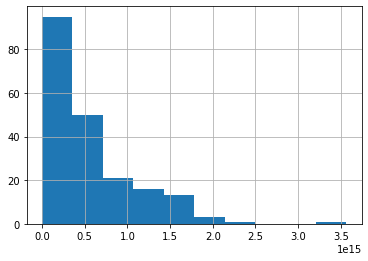

In [888]:
pd.Series(mape_).hist()

In [695]:
pd.Series(mape_).mean(),pd.Series(mape_).std()

(1683220360729723.0, 1671410313803153.2)

<AxesSubplot:>

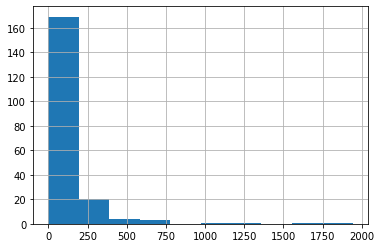

In [509]:
pd.Series(mse_).hist()

In [35]:
df_combined = df_combined[df_combined["13001_checkout"]>-1]

In [36]:
MAPE(df_combined["13001_checkout"].to_numpy(),df_combined["13001_checkout_fc"].to_numpy() ) 

0.5783858998144714

<AxesSubplot:>

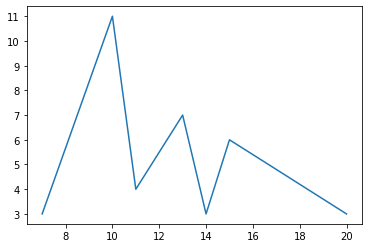

In [37]:
df_combined["13001_checkout"].plot()

<AxesSubplot:>

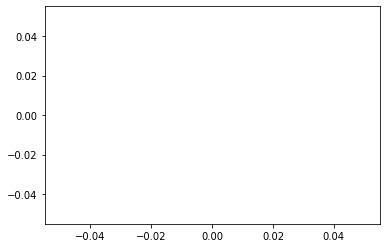

In [31]:
df_iid.y [df_iid.ID=="13001_checkout"].plot() 

In [ ]:
df_test["OT_x"]

In [ ]:
results.plot()

KeyboardInterrupt: 

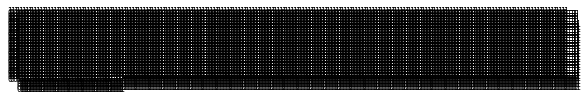

In [891]:
results.plot_acorr()

In [ ]:
model.select_order(15)

In [ ]:
results = model.fit(maxlags=15, ic='aic')

In [ ]:
lag_order = results.k_ar

In [ ]:
lag_order

In [41]:
results.forecast(data.values[-lag_order:], 50000)

NameError: name 'data' is not defined

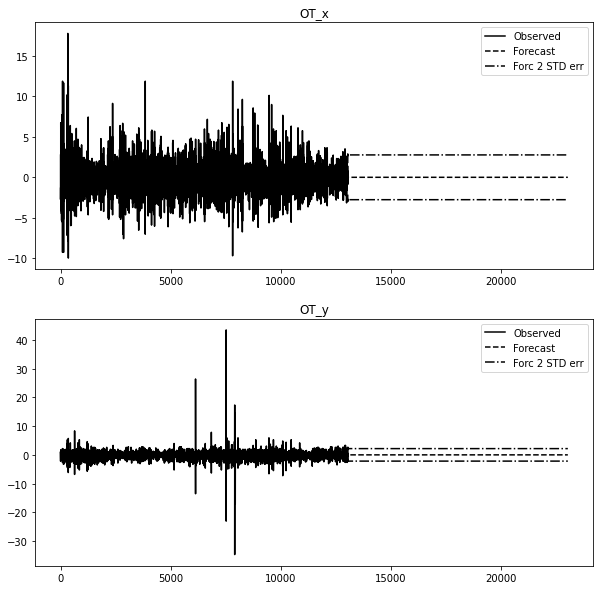

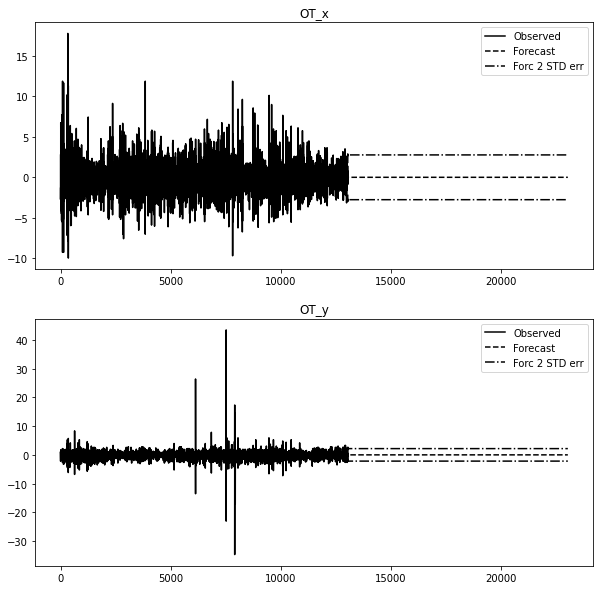

In [42]:
results.plot_forecast(10000)